# Active Learning for Text Classification using Small-Text

This is an introductory example that shows you how to use [small-text](https://github.com/webis-de/small-text) to perform active learning for text classification using classifiers provided by [sklearn](https://scikit-learn.org/).

In [1]:
%pip install small-text==1.3.0   

# additional dependencies for this example
%pip install datasets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\walid.aguiler\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\walid.aguiler\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
import warnings
import logging
warnings.filterwarnings('ignore')
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

# Data
First, we load the rotten tomatoes dataset. This dataset contains movie reviews sentences, which are labeled by their sentiment as either positive or negative.

In [22]:
raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = raw_dataset['train'].features['label'].num_classes

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

100%|██████████| 3/3 [00:00<00:00, 721.54it/s]

First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

In [23]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

We fix the random seeds so that readers do not get confused when the results change upon repeated execution.

In [31]:
import numpy as np
seed = 2023
np.random.seed(seed)
# load the dataset
train = raw_dataset['train']
test = raw_dataset['test']

## Preparing the Data

Next, we have to convert this raw text data into a format usable by small-text. For the feature extraction we use TF-IDF vectorizing.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1, 3))

We use the `SklearnDataset.from_arrays()` helper function which constructs a `SklearnDataset` instance using the vectorizer, text, and labels.

In [33]:
from small_text import SklearnDataset


target_labels = np.arange(num_classes)


train = SklearnDataset.from_arrays(np.array(train['text']),
                                        np.array(train['label']),
                                        vectorizer=vectorizer,
                                        target_labels=target_labels)

test = SklearnDataset.from_arrays(np.array(test['text']), 
                                       np.array(test['label']),
                                       vectorizer=vectorizer,
                                       target_labels=target_labels,
                                       train=False)

## Setting up the Active Learner
Now we constrauct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 10 sentences. This corresponds to an initial labeling the real-world setting.

In [34]:
from sklearn.linear_model import LogisticRegression

from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    SklearnClassifierFactory,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=200)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial


model = LogisticRegression(random_state=seed)

clf_factory = SklearnClassifierFactory(model, num_classes)
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

## Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next. We then provide the labels for those documents and the active learner retrains the model. After each query, we evaluate the current model against the test set and save the result.

Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators, and moreover, we would not be able to measure the test accuracy.

In [35]:
from sklearn.metrics import accuracy_score, f1_score


num_queries = 50


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = f1_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(f1_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

Train accuracy: 1.00
Test accuracy: 0.59
---------------
Iteration #0 (220 samples)
Train accuracy: 1.00
Test accuracy: 0.57
---------------
Iteration #1 (240 samples)
Train accuracy: 1.00
Test accuracy: 0.58
---------------
Iteration #2 (260 samples)
Train accuracy: 1.00
Test accuracy: 0.56
---------------
Iteration #3 (280 samples)
Train accuracy: 1.00
Test accuracy: 0.57
---------------
Iteration #4 (300 samples)
Train accuracy: 1.00
Test accuracy: 0.61
---------------
Iteration #5 (320 samples)
Train accuracy: 1.00
Test accuracy: 0.63
---------------
Iteration #6 (340 samples)
Train accuracy: 1.00
Test accuracy: 0.66
---------------
Iteration #7 (360 samples)
Train accuracy: 1.00
Test accuracy: 0.67
---------------
Iteration #8 (380 samples)
Train accuracy: 1.00
Test accuracy: 0.68
---------------
Iteration #9 (400 samples)
Train accuracy: 1.00
Test accuracy: 0.67
---------------
Iteration #10 (420 samples)
Train accuracy: 0.99
Test accuracy: 0.66
---------------
Iteration #11 (440

## Plotting the Results

Using the previously saved results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the resulting accuracy on the test set.

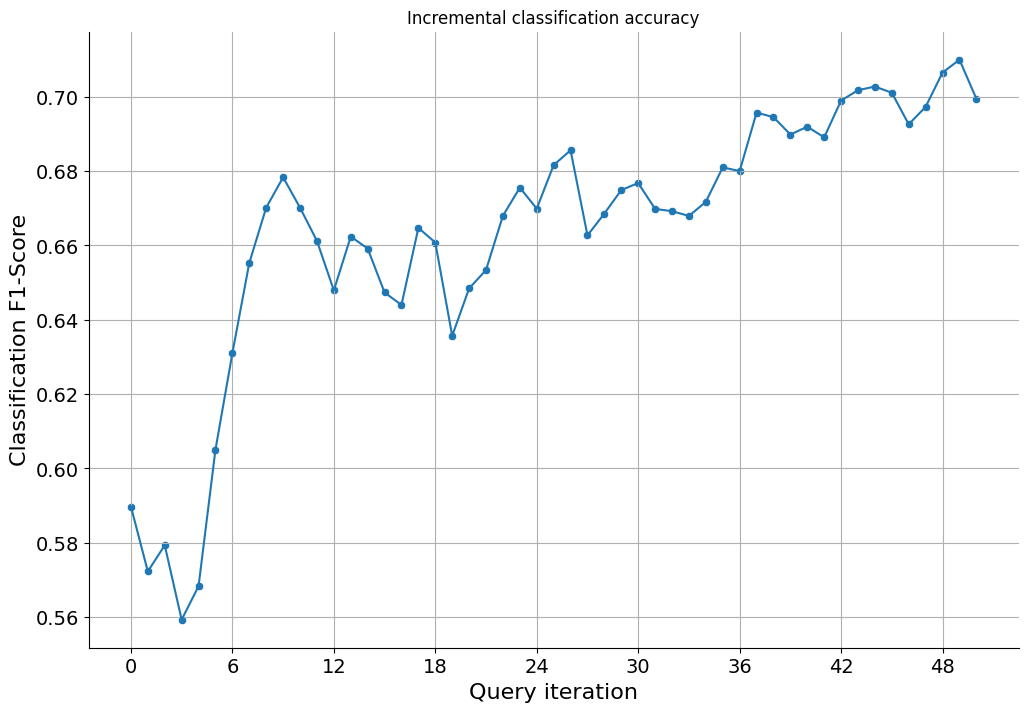

In [36]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=10, integer=True))
plt.grid()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)
sns.scatterplot(x=0, y=1, data=data)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1-Score')
sns.despine()